In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.abs import UnaryAbs
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def test(rng="Sobol", 
         mode="bipolar", 
         bitwidth=8, 
         total_cnt=100, 
         depth=5, 
         shiftreg=False, 
         interleave=False):
    stype = torch.float
    rtype = torch.float
    
    print("========================================================")
    print(mode)
    print("========================================================")
    # all input values are non-negative
    low_bound = 0
    if mode is "unipolar":
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        low_bound = -2**(bitwidth-1)
        up_bound = 2**(bitwidth-1)

    input_list = []
    for input_val in range(low_bound, up_bound+1, 1):
        input_list.append(input_val)
    
    input = torch.tensor(input_list).type(torch.float).div(up_bound).to(device)
#     input = torch.tensor([-1/256]).type(torch.float).div(up_bound).to(device)

    output = torch.abs(input).to(device)
    
    result_pe_total = []
    for rand_idx in range(1, total_cnt+1):
        outputPE = ProgressiveError(output, mode=mode).to(device)
    
        inputPE  = ProgressiveError(input,  mode=mode).to(device)
        inputSRC = SourceGen(input, bitwidth, mode=mode, rtype=rtype)().to(device)

        dut = UnaryAbs(depth=depth, shiftreg=shiftreg, interleave=interleave).to(device)
        
        inputRNG = RNG(bitwidth, rand_idx, rng, rtype)().to(device)
        inputBS = BSGen(inputSRC, inputRNG, stype).to(device)
        with torch.no_grad():
            start_time = time.time()
            for i in range(2**bitwidth):
                input_bs = inputBS(torch.tensor([i]))
                inputPE.Monitor(input_bs)

                _, output_bs = dut(input_bs)
                outputPE.Monitor(output_bs)
        
        # get the result for different rng
        result_pe = outputPE()[1].cpu().numpy()
        result_pe_total.append(result_pe)
    
    # get the result for different rng
    result_pe_total = np.array(result_pe_total)
    
    #######################################################################
    # check the error of all simulation
    #######################################################################
    print("RMSE:{:1.4}".format(np.sqrt(np.mean(result_pe_total**2))))
    print("MAE: {:1.4}".format(np.mean(np.abs(result_pe_total))))
    print("bias:{:1.4}".format(np.mean(result_pe_total)))
    print("max: {:1.4}".format(np.max(result_pe_total)))
    print("min: {:1.4}".format(np.min(result_pe_total)))

    #######################################################################
    # check the error according to input value
    #######################################################################
    max_total = np.max(result_pe_total, axis=0)
    min_total = np.min(result_pe_total, axis=0)
    avg_total = np.mean(result_pe_total, axis=0)
    
    axis_len = outputPE()[1].size()[0]
    input_x_axis = []
    for axis_index in range(axis_len):
        input_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
    fig, ax = plt.subplots()
    ax.fill_between(input_x_axis, max_total, avg_total, facecolor="red", alpha=0.75)
    ax.fill_between(input_x_axis, avg_total, min_total, facecolor="blue", alpha=0.75)
    ax.plot(input_x_axis, avg_total, label='Avg error', color="black", linewidth=0.3)
    plt.tight_layout()
    plt.xlabel('Input value')
    plt.ylabel('Output error')
    plt.xticks(np.arange(-1.1, 1.1, step=0.5))
    # ax.xaxis.set_ticklabels([])
    plt.xlim(-1, 1)
    plt.yticks(np.arange(-1.1, 1.1, step=0.2))
    # ax.yaxis.set_ticklabels([])
    plt.ylim(-1, 1)
    plt.grid(b=True, which="both", axis="y", linestyle="--", color="grey", linewidth=0.3)
    fig.set_size_inches(2, 2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    plt.close()

bipolar
RMSE:0.01307
MAE: 0.004554
bias:-0.004554
max: 0.0
min: -0.2188


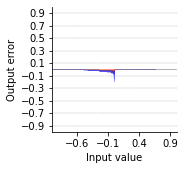

bipolar
RMSE:0.03497
MAE: 0.02074
bias:-0.02074
max: 0.0
min: -0.25


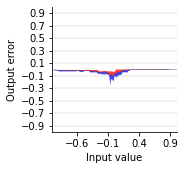

In [5]:
test(rng="Sobol", mode="bipolar", bitwidth=8, total_cnt=5, depth=5, shiftreg=False, interleave=False)
test(rng="SYS", mode="bipolar", bitwidth=8, total_cnt=5, depth=5, shiftreg=False, interleave=False)

bipolar
RMSE:0.05657
MAE: 0.02982
bias:-0.02982
max: 0.0
min: -0.2734


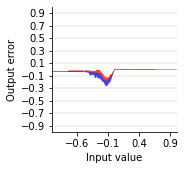

bipolar
RMSE:0.09773
MAE: 0.0624
bias:-0.06055
max: 0.05469
min: -0.3047


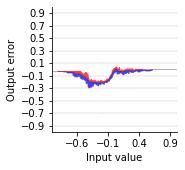

In [6]:
test(rng="Sobol", mode="bipolar", bitwidth=8, total_cnt=5, depth=8, shiftreg=True, interleave=False)
test(rng="SYS", mode="bipolar", bitwidth=8, total_cnt=5, depth=8, shiftreg=True, interleave=False)

bipolar
RMSE:0.08329
MAE: 0.06478
bias:-0.06478
max: -0.007812
min: -1.0


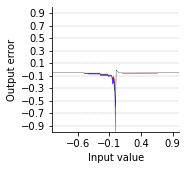

bipolar
RMSE:0.0659
MAE: 0.06438
bias:-0.06438
max: -0.02344
min: -0.2031


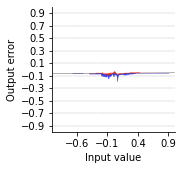

In [7]:
test(rng="Sobol", mode="bipolar", bitwidth=8, total_cnt=5, depth=5, shiftreg=False, interleave=True)
test(rng="SYS", mode="bipolar", bitwidth=8, total_cnt=5, depth=5, shiftreg=False, interleave=True)